# Image Classification using PyTorch


In [2]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import imageio

## 1. Load and visualise data.

The dataset is split into a training set of 60,000 images and a test set of 10,000 images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:

| Label       | Description |
| ----------- | ----------- |
| 0  |  T-shirt/top |
| 1  |  Trousers    |
| 2  |  Pullover    |
| 3  |  Dress       |
| 4  |  Coat        |
| 5  |  Sandal      |
| 6  |  Shirt       |
| 7  |  Sneaker     |
| 8  |  Bag         |
| 9  |  Ankle boot  |

In [3]:
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

### 1.1 Display the dimension of the training and test sets

In [4]:
print("Training images dimension: ", train_image.shape)
print("Training labels dimension: ", train_label.shape)

print("Test images dimensions: ", test_image.shape)
print("Test labels dimensions: ", test_label.shape)
print("Class Labels: ", class_name)

Training images dimension:  (60000, 28, 28)
Training labels dimension:  (60000,)
Test images dimensions:  (10000, 28, 28)
Test labels dimensions:  (10000,)
Class Labels:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### 1.2 Visualise sample images for each of the 10 classes.

Plotting 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

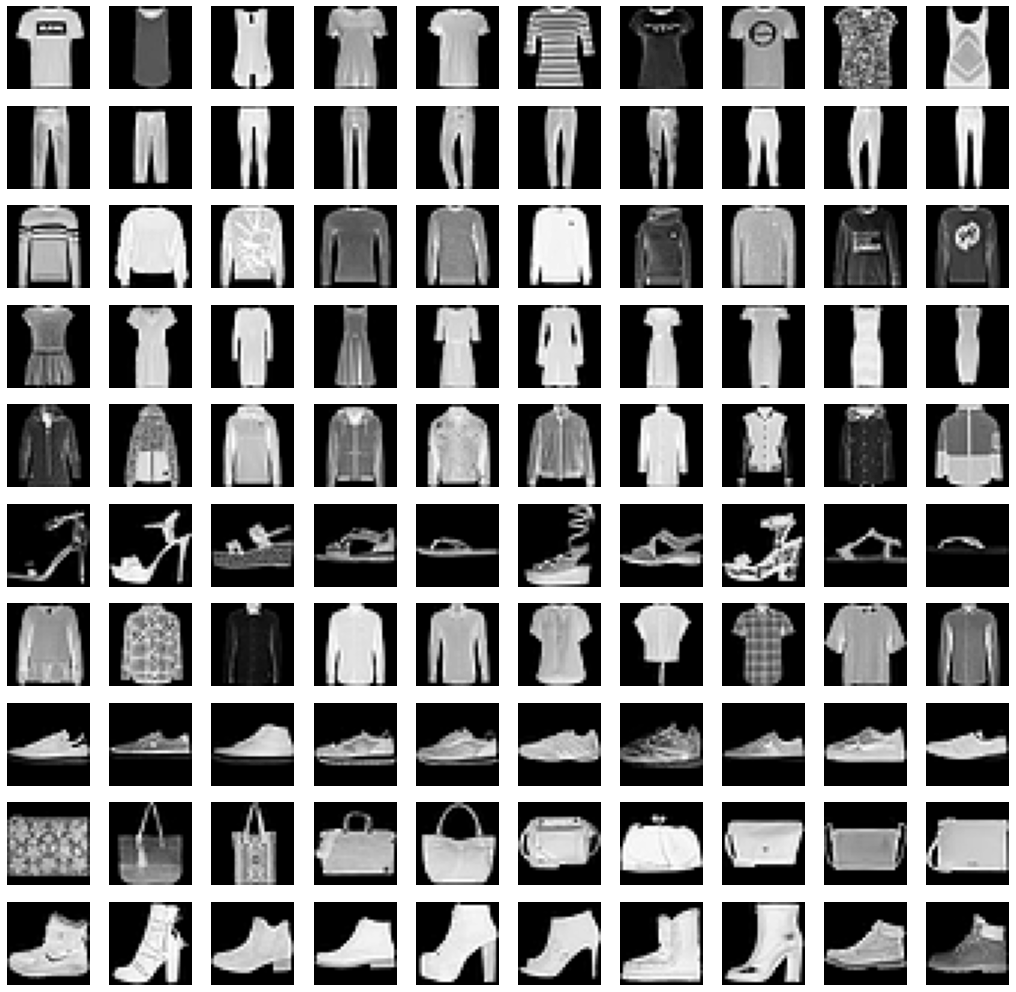

In [5]:
_, subplot_ax = plt.subplots(10,10,figsize=(18, 18))
for label in range(0,10):
    for instance in range(0,10):
        element = np.where(train_label==label)[0]
        subplot_ax[label,instance].axis('off')
        subplot_ax[label,instance].imshow(train_image[element[instance],:,:],cmap='gray')

### 1.3 Display the number of training samples for each class.

In [6]:
print("Number of instances per class label: ")
for label in range(10):
    print(class_name[label], ": ", len(train_image[train_label == label]))

Number of instances per class label: 
T-shirt/top :  6000
Trouser :  6000
Pullover :  6000
Dress :  6000
Coat :  6000
Sandal :  6000
Shirt :  6000
Sneaker :  6000
Bag :  6000
Ankle boot :  6000


## 2. Image classification

### 2.1 Building a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. 

I have designed a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Instantiating 2 Layers of 5x5 Convolutions
        self.convLayer1 = nn.Conv2d(1,6,5)
        self.convLayer2 = nn.Conv2d(6,16,5)
        #Instantiating fully connected layers
        self.fullConn1 = nn.Linear(256,120) #Down to 120
        self.fullConn2 = nn.Linear(120,84) #Down to 84
        self.fullConn3 = nn.Linear(84,10) #Down to 10


    def forward(self, x):
        # Forward propagation
        #Perform 2x2 max pooling after the convolution layers with ReLU activation
        x = F.max_pool2d(F.relu(self.convLayer1(x)), 2)
        x = F.max_pool2d(F.relu(self.convLayer2(x)), 2)
        x = x.view(x.size(0), -1)
        #Pass inputs through the Linear layers wuth ReLU activation for first 2 linear layers, linear activation in fina
        x = F.relu(self.fullConn1(x))
        x = F.relu(self.fullConn2(x))
        x = self.fullConn3(x)
        return x
    
# Since most of you use laptops, you may use CPU for training.
# If you have a good GPU, you can set this to 'gpu'.
device = 'cpu'

# Network
model = Net().to(device)

### 2.2 Defining the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc

In [8]:
#Like in LenNet, Loss Function set as CrossEntropyLoss since it is well-suited for multiclass-classifcation problems
loss_function = nn.CrossEntropyLoss()

#Defining Hyperparemeters
no_epochs = 100 #very low, but computational power not sufficient for more iterations
batch = 32
learning_rate = 0.001

#Using the Adam Method for Stochastic Optimisation
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3 Start model training

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent.

Printing out training loss and training time.

In [9]:
#Transforming Images to tensors to facilitate using a dataloader
trainset = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = False, transform = transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = False, transform = transforms.ToTensor())


In [10]:
time_start = time.clock_gettime(time.CLOCK_REALTIME)

for epoch in range(no_epochs):
    loss_per_epoch = 0
    
    #loading the training data from trainset and shuffling for each epoch
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle = True) 
    
    for i, batch_no in enumerate(trainloader, 0):
        
        #Put Model into train mode
        model.train()

        #Extract inputs and associated labels from dataloader batch
        inputs = batch_no[0].to(device) 
        labels = batch_no[1].to(device) 
        
        #Zero-out the gradients before backward pass (pytorch stores the gradients)
        optimiser.zero_grad()
        
        #Predict outputs (forward pass)
        predictions =  model(inputs)
    
        #Compute Loss
        loss = loss_function(predictions, labels)
    
        #Backpropagation
        loss.backward()
    
        #Perform one step of gradient descent
        optimiser.step()
        
        #Append loss to the general loss for this one epoch
        loss_per_epoch += loss.item()
    if epoch % 10 == 0:
        print("Loss for Epoch", epoch, ": ", loss_per_epoch)

time_end = time.clock_gettime(time.CLOCK_REALTIME)
time_passed = time_end - time_start
print()
print(f"{time_passed/60:.5} minutes ({time_passed:.3} seconds) taken to train the model")

Loss for Epoch 0 :  1162.7130333781242
Loss for Epoch 10 :  399.82982824184
Loss for Epoch 20 :  273.70807781163603
Loss for Epoch 30 :  196.06097039952874
Loss for Epoch 40 :  157.4969445960014
Loss for Epoch 50 :  125.58531304533244
Loss for Epoch 60 :  104.79787834977469
Loss for Epoch 70 :  99.38579961396954
Loss for Epoch 80 :  94.6728890297008
Loss for Epoch 90 :  77.38148596145993

23.877 minutes (1.43e+03 seconds) taken to train the model


### 2.4 Deploy the trained model onto the test set, evaluating how long it takes

In [11]:
#Switch to eval mode
model.eval()
no_total = 0
no_correct = 0
y_pred = np.array([])
time_start = time.clock_gettime(time.CLOCK_REALTIME)

#loading the test data from testset
testloader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False)

for batch_no in testloader:
    
    #Split dataloader
    inputs = batch_no[0].to(device) 
    labels = batch_no[1].to(device)     
    
    #Forward pass through the trained network
    outputs = model(inputs)
    
    #Get predictions and append to label array + count number of correct and total
    _, predictions = torch.max(outputs.data, 1)
    y_pred = np.append(y_pred, predictions.numpy())
    no_total += labels.size(0)
    no_correct += (predictions == labels).sum().item()

time_end = time.clock_gettime(time.CLOCK_REALTIME)
time_passed = time_end - time_start
print(f"{time_passed/60:.2} minutes ({time_passed:.2} seconds) taken to test the model")

0.023 minutes (1.4 seconds) taken to test the model


### 2.5 Evaluating the classification accuracy on the test set

In [12]:
accuracy = (no_correct / no_total)
print("Accuracy after training: ", accuracy)

Accuracy after training:  0.8917


### 2.6 Prining out and visualising the confusion matrix

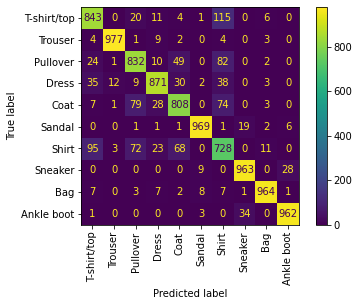

In [13]:
y_pred = y_pred.flatten()
confusion = metrics.confusion_matrix(test_label, y_pred)
confusion_visual = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_name)
confusion_visual.plot(xticks_rotation='vertical')

## 3. Deploy in real world.

Taking 3 photos that belongs to the 10 classes (e.g. clothes, shoes) from my own wardrobe. Used Gimp to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28. 

### 3.1 Loading and visualise my own images

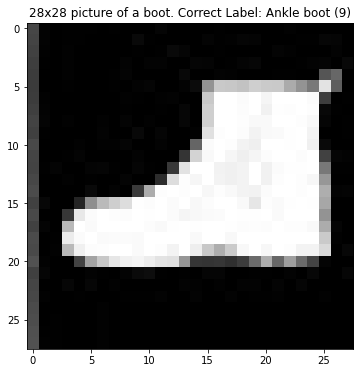

In [14]:
boot = imageio.imread('data/self/boot.jpg')
plt.title("28x28 picture of a boot. Correct Label: Ankle boot (9)")
plt.imshow(boot, cmap="gray")
plt.gcf().set_size_inches(8, 6)

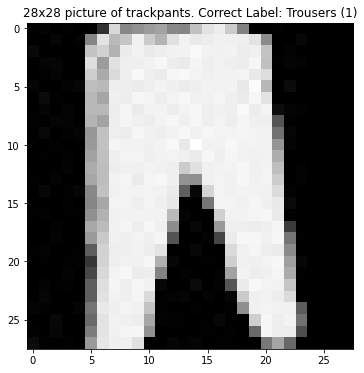

In [15]:
pants = imageio.imread('data/self/pants.jpg')
plt.title("28x28 picture of trackpants. Correct Label: Trousers (1)")
plt.imshow(pants, cmap="gray")
plt.gcf().set_size_inches(8, 6)

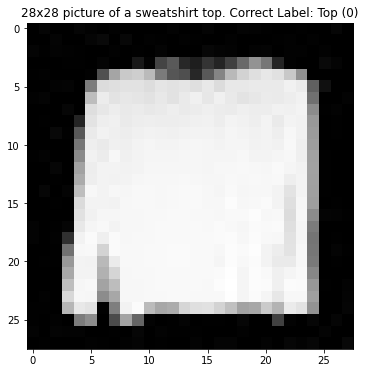

In [16]:
top = imageio.imread('data/self/top.jpg')
plt.title("28x28 picture of a sweatshirt top. Correct Label: Top (0)")
plt.imshow(top, cmap="gray")
plt.gcf().set_size_inches(8, 6)



In [17]:
#Loading the images and transforming them to tensors

transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder('data/', transform=transforms)

#Associating the appropriate ground truth labels
label_array = np.array([9,1,0])

### 3.2 Test your network on the real images and display the classification results

In [18]:
validationloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

classified_labels = np.array([])

for batch_no in validationloader:
    inputs = batch_no[0].to(device) 
    output = model(inputs)
    _, predictions = torch.max(output.data, 1)
    classified_labels = np.append(classified_labels, predictions.numpy())

classified_labels = classified_labels.astype(int)    
for i in range(3):
    print("Gold Standard Label: ", class_name[label_array[i]], "| Predicted Label: ", class_name[classified_labels[i]])


Gold Standard Label:  Ankle boot | Predicted Label:  Ankle boot
Gold Standard Label:  Trouser | Predicted Label:  Trouser
Gold Standard Label:  T-shirt/top | Predicted Label:  Bag


### 3.3 Comments on the classification results.


The model correctly identified two out of the three sample images. The ankle boot and trouser images were correctly labelled, which is not surprising since, as we can see in the confusion matrix, these two labels are generally identified with high accuracy (high precision and recall). T-shirts/Tops, however, are more frequently misclassified (only around 80% accuracy on the test set). This pattern is thus repeating itself when tested on further data. We can say that the model works for inputs objects that have a very distinct shape (such as a trouser and a boot), but has more difficulties with objects showing similarities of shape. Furthermore, we have to note that the model works for inputs that have been preprocessed in a very specific way (cutting, centering, background colour inversion, downsampling). As such, this tests give no indication as to whether our classifier would work on images that are not preprocessed so intensely.

There are various ways we can improve on the real-life performance on the model. 

More data:
One possibility includes increasing the training datapoints for each category. It could be that the training data does not feature many long-sleeved tops, and as such the classifier failed on this category. This could also be achieved by data augmentation, that is, by taking the existing training data and slightly varying it (different scale, different rotation), to create a classifier that is more capable of dealing with variations in the inputs. 

Hyperparameter tuning/Preventing overfitting: 
Alternatively, we could also further tune the hyperparameters that are present in the model, such as learning rate and number of epochs. For some classifiers, shorter training times and earlier stopping (less epochs) actually increases performance, since we reduce the risk for overfitting. Other methods that can be used here include L1- or L2-regularisation, to get a sparser estimator. 

Deeper network:
One may also consider designing a deeper network with more hidden layers (such as many small convolutions like in a VGG). This, however, is not really possible in the current case since my CPU also struggled with training the relatively small LeNet approximation designed here, so a much deeper network will likely require a GPU.

Higher-dimensional input:
In this specific case, we may want to consider training a network on input images with more pixels. We can see that after the preprocessing, the pixelation has substantially blurred the shirts sleeve, which is any t-shirts defining feature. What is left looks more like a large square block (which can easily misclassified as a bag, as the predicted result suggests). Potentially using more detailed input images could boost performance since the actual features of the inputs are more visible and thus easier to detect for the classifier. 